# Task 1: Linear Triangulation [15]

**Please go through the notebook once before beginning working on it!**

The goal of this section is to understand the geometric relationships between multiple views of a scene. Linear triangulation is a fundamental step in 3D reconstruction pipelines. It involves estimating the 3D coordinates of points in a scene using projections onto two or more images taken from different camera perspectives. This process is essential because it allows us to map the 2D image features into the 3D world, providing a foundation for building more detailed 3D models.

In this notebook you will:
1. Pre-process the dataset and extract key features from the images using feature detection methods such as **SIFT** or **ORB**.
2. Match these features across image pairs to identify corresponding points.
3. Compute the fundamental and essential matrices to estimate the relative poses of the cameras.
4. Use linear triangulation to determine the 3D coordinates of a point in space and visualize it.

<span style="color: red">**Submission Guidelines:**</span> Only one member of each group has to submit the file on LMS. The name of the file should be your group number. For example, if you are Group 1 then the file name should be **G01_Deliverable1.ipynb**. If you are unsure about your group number, then you can confirm it in the [sheet](https://docs.google.com/spreadsheets/d/1vN6JOLDWoFR5BnXTr0lMYGv_e9VzyAbqSUqf4VdjCQI/edit?gid=0#gid=0) 

#### Imports

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# add imports here
from read_write_model import read_cameras_binary, read_images_binary, read_points3D_binary

### Dataset
We will use the [Heritage-Recon](https://drive.google.com/drive/folders/1eZvmk4GQkrRKUNZpagZEIY_z8Lsdw94v) dataset, which contains sets of images of various landmarks captured from multiple angles. You can choose one landmark for your project and use its dataset for this task.

If you go through the dataset, you will find the images for your landmark in the **dense/images** folder. There are also some other important files that you will see. For example, the root directory of the brandenburg gate dataset contains the **brandenburg_gate.ply**, which is the actual 3D model generated from the dataset. You will generating something similar for the next deliverable as well.

The **neuralsfm** folder contains three key **.bin** files, which are binary files commonly used in Structure from Motion (SfM) pipelines like COLMAP for storing 3D reconstruction data:
1. cameras.bin: stores information about the cameras used in the SfM process. It includes intrinsic parameters, such as focal lengths and principal points, as well as extrinsic parameters that define the camera's position and orientation.
2. images.bin: contains the images’ pose information within the 3D space. It also includes 2D keypoints detected in each image and their associations with 3D points. This file is crucial for understanding where each image is located in the reconstructed scene.
3. points3D.bin: holds information about the reconstructed 3D points, including their 3D coordinates, color, and visibility across images. It essentially represents the sparse point cloud of the scene, where each point correlates with specific 2D keypoints in the images.

The **semantic_maps** folder contains .npz files that store semantic segmentation data in a compressed format. Each .npz file corresponds to a semantic map or segmentation mask for a particular image, with classes or labels encoded as numerical values.

### Loading in our data

Load in 3 different images from the images folder and display them.

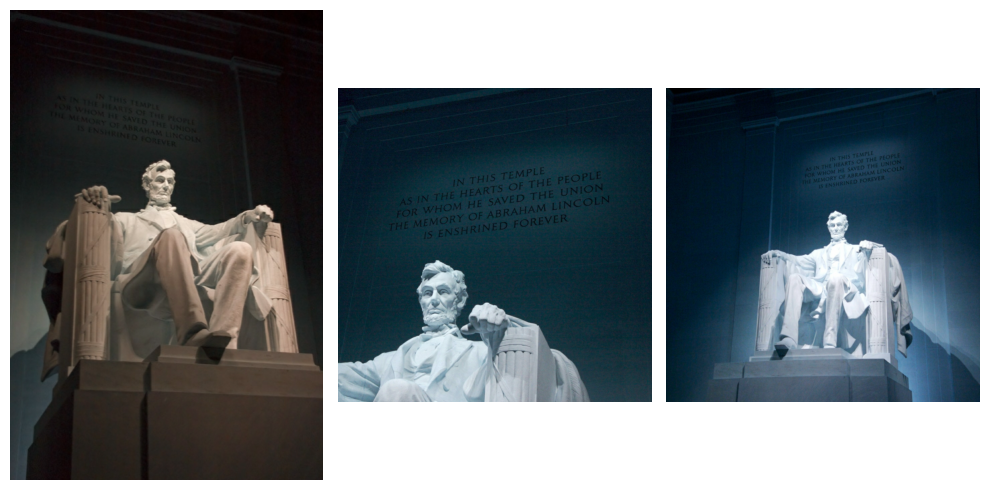

In [2]:
images_folder = './lincoln_memorial/dense/images'
display_images = []

# Loading three images
for file_idx, file_name in enumerate(os.listdir(images_folder)):
    if file_idx >= 3:
        break
    file_path = os.path.join(images_folder, file_name)
    image = cv2.imread(file_path)
    display_images.append(image)

# Displaying images
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for idx, image in enumerate(display_images):
    ax[idx].imshow(image)
    ax[idx].axis('off')
    
plt.tight_layout()
plt.show()

#### Pre-processing

If you go through the images in the dataset you will notice images with varying dimensions, angles, brightness levels etc. For us to effectively use our dataset, we first need to pre-process our images. Pre-processing ensures that the images are prepared consistently for feature detection, matching, and camera pose estimation.

Some helper functions that might be useful.

In [23]:
def get_img_paths(folder_pth):
    """Returns a list containing filenames of all jpg files in folder_pth"""
    jpg_files = []

    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            # uncomment the line below if you want to include the entire path in the filename
            filename = os.path.join(folder_pth, filename)
            jpg_files.append(filename)

    return jpg_files

def load_images(folder_pth):
    """Loads all images in folder_path"""
    images = []
    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg") or filename.lower().endswith(".png"):
            img = cv2.imread(os.path.join(folder_pth, filename))
            images.append(img)

    return images

def resize_image(img, size=(800, 600)):
    """Resizes image to a specified size."""
    return cv2.resize(img, size)


def convert_to_grayscale(img):
    """Converts an image to grayscale."""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# you can add other functions here as well.
def show_image(image):
    plt.figure(figsize=(10, 7))
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def show_images(image_list):
    fig, ax = plt.subplots(1, len(image_list), figsize=(5*len(image_list), 5))
    ax.flatten()
    for image_idx, image in enumerate(image_list):
        ax[image_idx].imshow(image)
        ax[image_idx].axis('off')
        
    plt.tight_layout()
    plt.show()

def drawlines(img1, img2, lines, pts1, pts2):
    r, c, _ = img1.shape
    
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        pt1 = (int(pt1[0]), int(pt1[1]))
        pt2 = (int(pt2[0]), int(pt2[1]))
        
        color = tuple(np.random.randint(0,255,3).tolist())
        
        x0, y0 = map(int, [0, -r[2]/r[1] ])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
        
    return img1, img2

def linear_triangulation(P1, P2, masked_pts1, masked_pts2):
    points_3d = []
    for pts1, pts2 in zip(masked_pts1, masked_pts2):
        u1, v1 = pts1
        u2, v2 = pts2
        
        A = np.zeros((4, 4))
        A[0] = u1 * P1[2, :] - P1[0, :]
        A[1] = v1 * P1[2, :] - P1[1, :]
        A[2] = u2 * P2[2, :] - P2[0, :]
        A[3] = v2 * P2[2, :] - P2[1, :]

        _, _, Vt = np.linalg.svd(A)
        
        point_3d = Vt[-1] / Vt[-1, 3]
        points_3d.append(point_3d)
    
    return np.array(points_3d)    

def compute_projection_matrix(K, R, T):
    RT = np.hstack((R, T))
    P = np.dot(K, RT)
    return P

def project_and_display_pts(image, P, points_3d):
    points_2d_homogenous = (P @ points_3d.T).T
    points_2d = points_2d_homogenous[:, :2] / points_2d_homogenous[:, 2:]

    plt.figure(figsize=(7, 7))
    plt.imshow(image)
    for point in points_2d:
        plt.scatter(point[0], point[1], c='red', s=5)  # Red dots for points
    plt.title("Projected 3D Points on Image")
    plt.axis('off')
    plt.show()
    

Now, load the images from the dataset folder, apply the pre-processing steps, and display few of the pre-processed images to verify. I have included a few types of pre-processing methods above, but you can use any other method as well that you believe might be helpful. Give a two-liner explaination for your pre-processing choices.

**Ans:**

In [4]:
image_paths_folder = get_img_paths(images_folder)

preprocessed_images = []
for file_path in image_paths_folder:
    image = cv2.imread(file_path)
    resized_image = resize_image(image)                 # Resizing the image for size consistnecy
    gray_image = convert_to_grayscale(resized_image)    # Converting to grayscale
    preprocessed_images.append(gray_image)
    

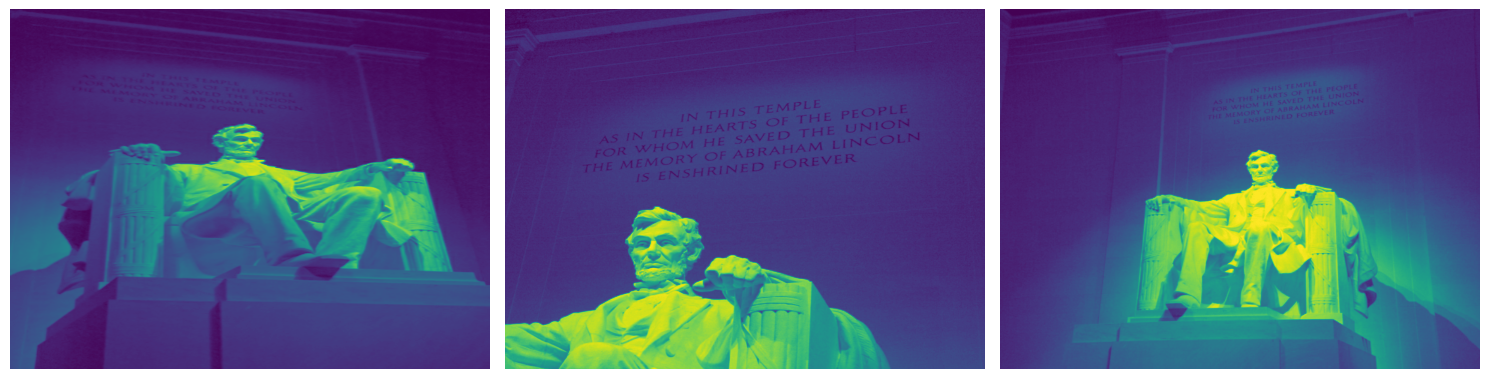

In [5]:
image_list = []
for preprocessed_image_idx, preprocessed_image in enumerate(preprocessed_images):
    if preprocessed_image_idx >= 3:
        break
    image_list.append(preprocessed_image)

show_images(image_list)

### Feature Detection

The goal is to identify distinct and robust points in the images that can be matched across different views. These feature points are the key to establishing correspondences between images.

There are several feature detection algorithms such as SIFT, SURF, or ORB available in the cv2 library. When using any of the algorithms, be sure to check the format of the image that it accepts.

Using any feature detection algorithm, extract the features from two images and display the images with the features higlighted on them. Here is an example:

<img src="assets/feature_detection.png" alt="My Image" width="800"/>

**Loading test images**

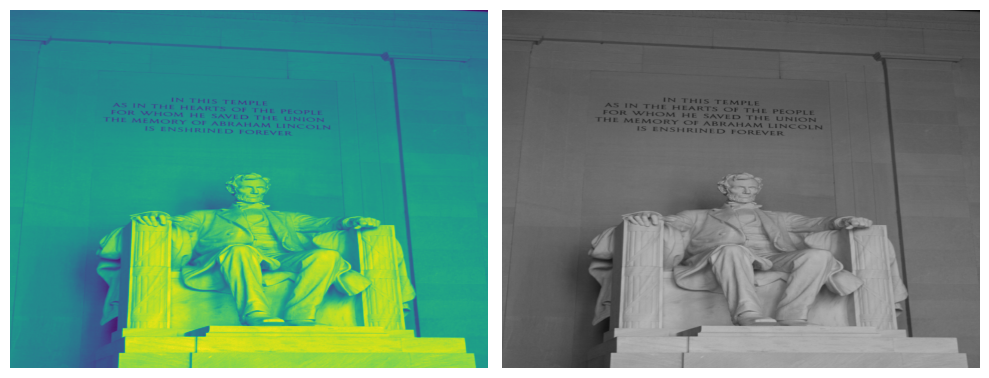

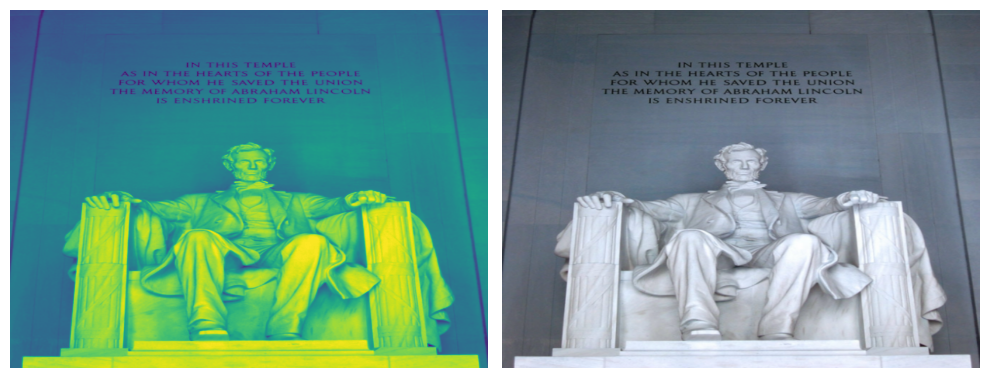

In [7]:
image_1_path = "./lincoln_memorial/dense/images/4051992220_0fc657cb75_o.jpg"
image_1_name = "4051992220_0fc657cb75_o.jpg"

image_2_path = "./lincoln_memorial/dense/images/3464969978_aa44596569_o.jpg"
image_2_name = "3464969978_aa44596569_o.jpg"

test_image_paths = [image_1_path, image_2_path]
test_images = [cv2.imread(img_path) for img_path in test_image_paths]

preprocessed_test_images = []
for test_image_idx, test_image in enumerate(test_images):
    resized_image = resize_image(test_image)
    test_images[test_image_idx] = resized_image
    
    gray_image = convert_to_grayscale(resized_image)
    preprocessed_test_images.append(gray_image)

for pimg, img in zip(preprocessed_test_images, test_images):
    show_images([pimg, img])

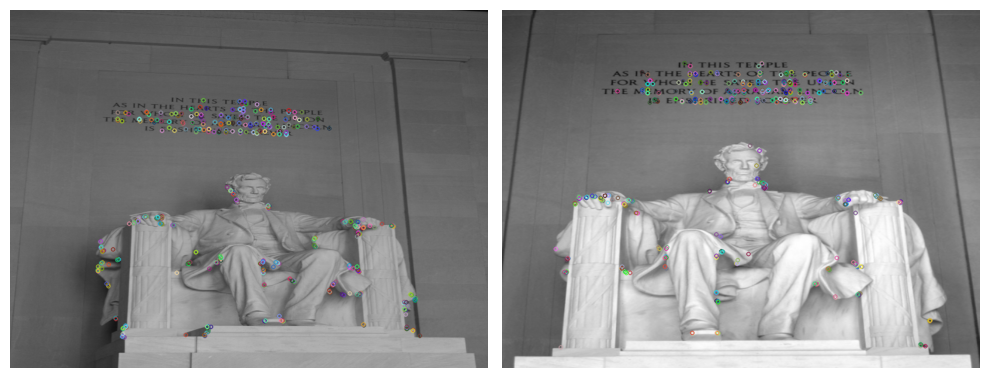

In [8]:
# Loading pre-processed and corresponding unprocessed images
p_image_1 = preprocessed_test_images[0]
image_1 = test_images[0]

p_image_2 = preprocessed_test_images[1]
image_2 = test_images[1]

# Initializing the SIFT detector
orb = cv2.ORB_create()

# Finding the keypoints nad descriptors
keypoints_1, descriptors_1 = orb.detectAndCompute(p_image_1, None)
keypoints_2, descriptors_2 = orb.detectAndCompute(p_image_2, None)

# Drawing keypoints
kp_image_1 = cv2.drawKeypoints(p_image_1.copy(), keypoints_1, image_1.copy())
kp_image_2 = cv2.drawKeypoints(p_image_2.copy(), keypoints_2, image_2.copy())
show_images([kp_image_1, kp_image_2])


### Feature Matching

Feature matching is a crucial step in 3D reconstruction because it helps find corresponding points between different images. Once you've detected the keypoints and descriptors using a feature detector, the next step is to match these descriptors across pairs of images.


Use the keypoints and descriptors extracted above for the two images and match the features across the two images. You can use this as a reference image:

<img src="assets/feature_matching.png" alt="My Image" width="800"/>

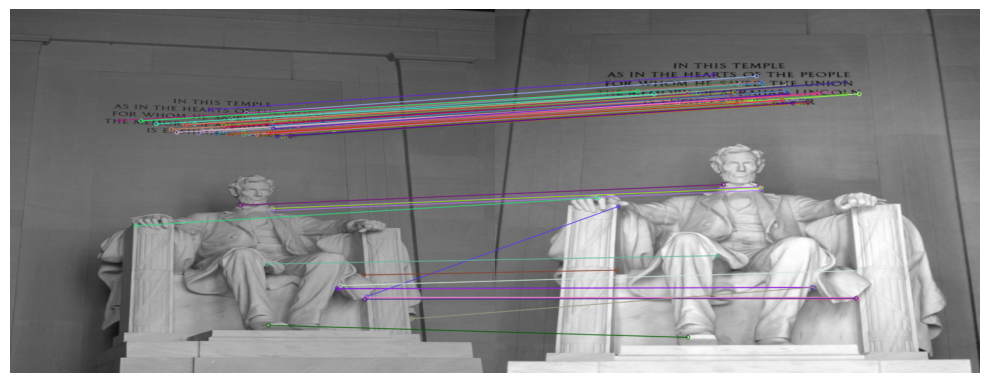

In [9]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Matching the descriptors
matches = bf.match(descriptors_1, descriptors_2)

# Sorting the matches in the order of their distance
matches = sorted(matches, key=lambda x:x.distance)

# Drawing the first 80 matches
matched_image = cv2.drawMatches(p_image_1, keypoints_1, p_image_2, keypoints_2, matches[:80], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

show_image(matched_image)

### Camera Pose Estimation

Camera pose estimation involves determining the relative position and orientation (i.e., rotation and translation) of the camera between two views. This is typically done by estimating the essential matrix or fundamental matrix between two sets of matched keypoints, and then decomposing these matrices to recover the camera pose.

So essentially:
1. Find the **fundamental matrix (F)** using the matched keypoints.
2. Decompose the **essential matrix (E)** into the rotation and translation components.
3. Use epipolar geometry to verify or refine the solution.

You can use the lecture slides as reference for computing these. 

Calculate the fundemental and essential matrices. Use these to recover the translation and rotation matrices.

In [10]:
# COLMAP
sfm_folder = './lincoln_memorial/neuralsfm'
cameras_bin = os.path.join(sfm_folder, 'cameras.bin')
images_bin = os.path.join(sfm_folder, 'images.bin')
points3D_bin = os.path.join(sfm_folder, 'points3D.bin')

# Parsing the sfm files
def parse_files(cameras_bin, images_bin, points3D_bin):
    cameras = read_cameras_binary(cameras_bin)
    images = read_images_binary(images_bin)
    points3D = read_points3D_binary(points3D_bin)
    
    return cameras, images, points3D

cameras, images, points3D = parse_files(cameras_bin, images_bin, points3D_bin)

In [11]:
preview = 3

print("Cameras:")
for idx, (cam_id, cam) in enumerate(cameras.items()):
    if idx == preview:
        break
    print(f"Camera ID: {cam_id} - Model: {cam.model} - Width: {cam.width} - Height: {cam.height} - Focal length: ({cam.params[0]}, {cam.params[1]}) - Principal point: ({cam.params[2]}, {cam.params[3]})")
    
print("\nImage:")
for idx, (image_id, image) in enumerate(images.items()):
    if idx == preview:
        break
    print(f"Image ID: {image_id} - Name: {image.name} - Camera ID: {image.camera_id}")
    
print("\nPoints3D:")
for idx, (pt_id, pt) in enumerate(points3D.items()):
    if idx == preview:
        break
    print(f"Points ID: {pt_id} - Coordinates: {pt.xyz}")

Cameras:
Camera ID: 708 - Model: PINHOLE - Width: 1600 - Height: 1182 - Focal length: (1628.6739393939395, 1628.5904347826088) - Principal point: (800.0, 591.0)
Camera ID: 707 - Model: PINHOLE - Width: 1600 - Height: 1180 - Focal length: (1617.8517179023509, 1618.5296811120195) - Principal point: (800.0, 590.0)
Camera ID: 706 - Model: PINHOLE - Width: 1600 - Height: 1198 - Focal length: (3313.5442092154417, 3314.901880199667) - Principal point: (800.0, 599.0)

Image:
Image ID: 708 - Name: 3323997727_3eddea30f4_o.jpg - Camera ID: 708
Image ID: 707 - Name: 3323705220_ce208e62f0_o.jpg - Camera ID: 707
Image ID: 706 - Name: 3323695992_16379bb312_o.jpg - Camera ID: 706

Points3D:
Points ID: 4015734 - Coordinates: [-3.36310092 -4.72929749  8.63601629]
Points ID: 4015733 - Coordinates: [-0.33325007  0.52304726  5.38279681]
Points ID: 4015732 - Coordinates: [-0.17462091 -2.05130073  6.14241856]


In [13]:
# Creating fundamental matrix F
matched_points_1 = np.array([keypoints_1[m.queryIdx].pt for m in matches], dtype=np.float32)
matched_points_2 = np.array([keypoints_2[m.trainIdx].pt for m in matches], dtype=np.float32)

F, mask = cv2.findFundamentalMat(matched_points_1, matched_points_2, method=cv2.FM_RANSAC)

# Taking inlier points and disgarding outlier points
masked_pts1 = matched_points_1[mask.ravel() == 1]
masked_pts2 = matched_points_2[mask.ravel() == 1]

# Getting test image data
image_1_id, image_2_id = None, None

# Getting camera id's
for image_id, image in images.items():
    if image_1_name == image.name:
        image_1_id = image_id
    if image_2_name == image.name:
        image_2_id = image_id

# Acquiring camera information     
img1_cam = cameras[image_1_id]
img2_cam = cameras[image_2_id]

# Extracting focal length (fl) and prinipal points (pp) from camera information
# and creating camera view matrix
img1_fl = (img1_cam.params[0], img1_cam.params[1])
img1_pp = (img1_cam.params[2], img1_cam.params[3])
K1 = np.array([
    [img1_fl[0], 0, img1_pp[0]],
    [0, img1_fl[1], img1_pp[1]],
    [0,          0,          1],
])

img2_fl = (img2_cam.params[0], img2_cam.params[1])
img2_pp = (img2_cam.params[2], img2_cam.params[3])
K2 = np.array([
    [img2_fl[0], 0, img2_pp[0]],
    [0, img2_fl[1], img2_pp[1]],
    [0,          0,          1],
])

# Computing essential matrix
E = K2.T @ F @ K1 
_, R, T, _ = cv2.recoverPose(E, masked_pts1, masked_pts2, K1)

# Print the Rotation and Translation matrices
print("Rotation Matrix R:\n", R)
print()
print("Translation Vector T:\n", T)

Rotation Matrix R:
 [[ 0.99926434 -0.03519851 -0.01522657]
 [ 0.03595593  0.99796194  0.05271755]
 [ 0.01333996 -0.05322626  0.99849337]]

Translation Vector T:
 [[ 0.25938467]
 [ 0.15393235]
 [-0.95342772]]


**validation of fundamental and essential matrix**

In [29]:
# Check if R is a valid rotation matrix
is_valid_rotation = np.allclose(R.T @ R, np.eye(3))
det_R = np.linalg.det(R) 

print("Is R a valid rotation matrix? ", is_valid_rotation)
print("Determinant of R: ", det_R)

magnitude_T = np.linalg.norm(T)
print("Magnitude of translation vector T:", magnitude_T)

Is R a valid rotation matrix?  True
Determinant of R:  1.0
Magnitude of translation vector T: 0.9999999999999999


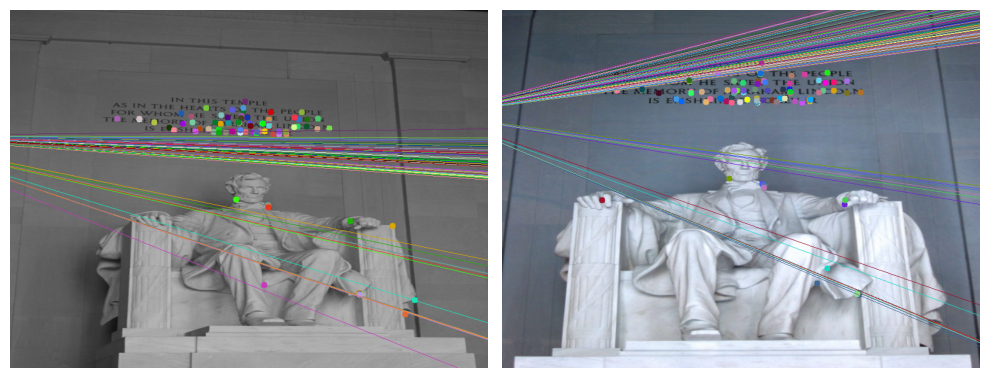

In [30]:
# Getting test images
img1 = test_images[0]
img2 = test_images[1]

# Computing epilines using fundamental matrix F and matched keypoints
img2_lines = cv2.computeCorrespondEpilines(masked_pts1.reshape(-1, 1, 2), 2, F)
img2_lines = img2_lines.reshape(-1,3)

img1_epilines, _ = drawlines(img1.copy(), img2.copy(), img2_lines, masked_pts1, masked_pts2)

img1_lines = cv2.computeCorrespondEpilines(masked_pts2.reshape(-1,1,2), 1,F)
img1_lines = img1_lines.reshape(-1,3)

img2_epilines, _ = drawlines(img2.copy(), img1.copy(), img1_lines, masked_pts2, masked_pts1)

show_images([img1_epilines, img2_epilines])

### Linear Triangulation

Linear triangulation involves determining the 3D coordinates of a point in space based on its projections in two or more images taken from different viewpoints. Given two camera poses and the corresponding 2D feature points in both images, linear triangulation allows you to estimate the 3D coordinates of the points in the scene.

Compute the 3D coordinates of the matched feature points by solving the system of equations derived from the camera projection equations above.

In [16]:
R1, T1 = np.eye(3), [[0], [0], [0]]
P1 = compute_projection_matrix(K1, R1, T1)
P2 = compute_projection_matrix(K2, R, T)

points_3d = linear_triangulation(P1, P2, masked_pts1, masked_pts2)
points_3d_homogenous = points_3d[:, :3] / points_3d[:, 3][:, None]

Visualise the 3D points obtained above. The results will probably not make any sense atm since we are only using two images, but this will help us in Task 2.

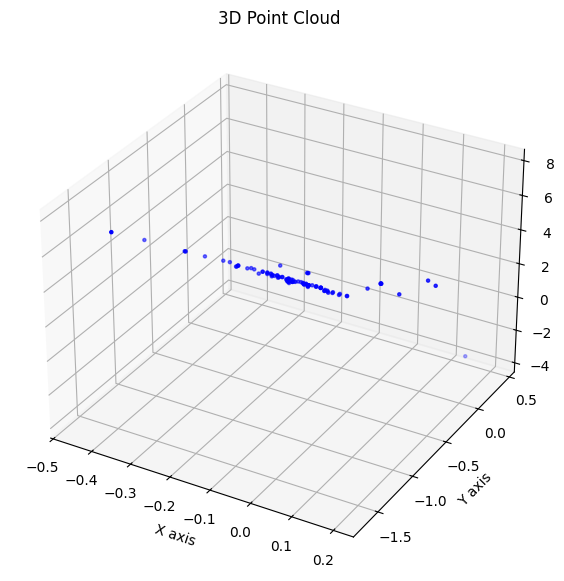

In [26]:
# Creating a 3D visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 3D points
x = points_3d_homogenous[:, 0]
y = points_3d_homogenous[:, 1]
z = points_3d_homogenous[:, 2]

# Scatter plot of the 3D points
ax.scatter(x, y, z, c='blue', marker='o', s=5)
ax.set_title("3D Point Cloud")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
plt.show()

**Validation of projected 3d points**

In [28]:
# Reprojecting 3d points to 2d
points_2d_reproj_1 = (P1 @ points_3d.T).T
points_2d_reproj_1 /= points_2d_reproj_1[:, 2:3]

points_2d_reproj_2 = (P2 @ points_3d.T).T
points_2d_reproj_2 /= points_2d_reproj_2[:, 2:3]

# Computing reprojection error
error_1 = np.linalg.norm(points_2d_reproj_1[:, :2] - masked_pts1, axis=1)
error_2 = np.linalg.norm(points_2d_reproj_2[:, :2] - masked_pts2, axis=1)

print("Reprojection error in image 1:", np.mean(error_1))
print("Reprojection error in image 2:", np.mean(error_2))

Reprojection error in image 1: 11.272827452003392
Reprojection error in image 2: 30.25319489470065


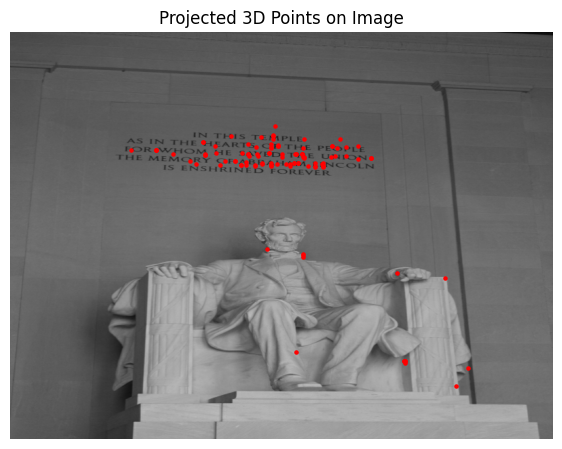

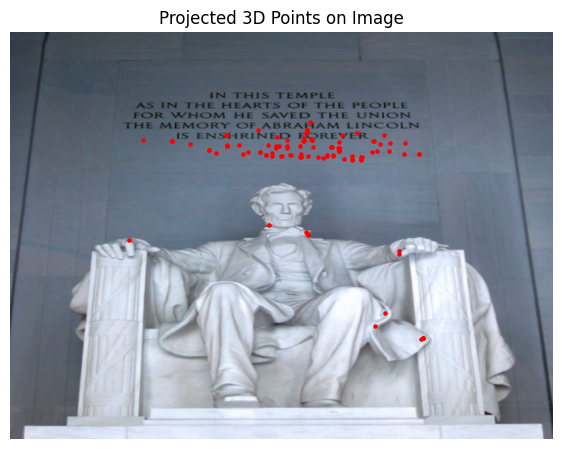

In [27]:
project_and_display_pts(img1, P1, points_3d)
project_and_display_pts(img2, P2, points_3d)